In this notebook we demonstrate how to leverage [FinBert](https://github.com/ProsusAI/finBERT) to classify the sentiment of a stocks.<br>You can download pre-trained FinBERT from [here](https://drive.google.com/drive/folders/1rcRXZhb3JLY3A_kIO8gMk8jacRyR-Ik6)

In [0]:
# https://drive.google.com/file/d/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL/view?usp=sharing 
# https://drive.google.com/file/d/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN/view?usp=sharing

Huge shoutout to this [article](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99) which helped in using wget to download the pre-trained model.<br>
To Download any version of FinBERT follow these steps:
1. Open the drive link and open the folder of the model you want to download
2. Right click on a file in the folder and select "get sharable link" option
3. Copy the part after 'd/' in the sharable URL
4. Replace the ID youve obtained intead of the id in the wget url if its different.
5. Repeat the process for the other file in the folder<br>
`!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O pytorch_model.bin && rm -rf /tmp/cookies.txt `

### Model Weights

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL" -O pytorch_model.bin && rm -rf /tmp/cookies.txt

--2020-06-03 13:46:51--  https://docs.google.com/uc?export=download&confirm=mTWR&id=1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL
Resolving docs.google.com (docs.google.com)... 172.217.203.100, 172.217.203.138, 172.217.203.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-1s-docs.googleusercontent.com/docs/securesc/p2jgqfea5lpvi9t30a0mh5qee7jl6ul4/71vece8u1gc2o64ve0vkbil306fgp7qv/1591191975000/03819273116678412817/07892353702974641314Z/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL?e=download [following]
--2020-06-03 13:46:51--  https://doc-0o-1s-docs.googleusercontent.com/docs/securesc/p2jgqfea5lpvi9t30a0mh5qee7jl6ul4/71vece8u1gc2o64ve0vkbil306fgp7qv/1591191975000/03819273116678412817/07892353702974641314Z/1ycRUIpll2tfooWRvsinNzM_6B5tz3EtL?e=download
Resolving doc-0o-1s-docs.googleusercontent.com (doc-0o-1s-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Conne

# Config.json

In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN" -O config.json && rm -rf /tmp/cookies.txt

--2020-06-03 13:47:15--  https://docs.google.com/uc?export=download&confirm=&id=1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN
Resolving docs.google.com (docs.google.com)... 172.217.203.100, 172.217.203.138, 172.217.203.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1g-docs.googleusercontent.com/docs/securesc/kqkqjae01qsvjsmmsdoi1baho0ambc4g/u1gn55kprdm4m2ngfre0sngthsa4m7lu/1591191975000/03819273116678412817/06303696199905918493Z/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN?e=download [following]
--2020-06-03 13:47:15--  https://doc-10-1g-docs.googleusercontent.com/docs/securesc/kqkqjae01qsvjsmmsdoi1baho0ambc4g/u1gn55kprdm4m2ngfre0sngthsa4m7lu/1591191975000/03819273116678412817/06303696199905918493Z/1MJMEeVLBdQ79F1TUewP_WR0uFzR81UPN?e=download
Resolving doc-10-1g-docs.googleusercontent.com (doc-10-1g-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connectin

#Vocabulary
Finbert drive link does not have a vocab.txt file. In the FinBERT repo they have mentioned that the same vocab file was used as for the 'bert-base-uncased' model. So we are going to download the vocab.txt of the 'bert-base-uncased' model

In [35]:
!wget "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"

--2020-06-03 14:07:31--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  --.-KB/s    in 0.05s   

2020-06-03 14:07:31 (4.33 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



### Move all the files into a FinBERT directory. This is the format that is required by the huggingface transformers library

In [0]:
!mkdir finbert
!mv pytorch_model.bin finbert/
!mv config.json finbert/
!mv bert-base-uncased-vocab.txt vocab.txt
!mv vocab.txt finbert/

### Installing packages

In [6]:
!pip install pytorch_transformers
!pip install transformers

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 890kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 15.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7871806c96a559cc4407566a5077b904b1026e57506fe2b6f2bfa76419e7a622
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 675kB 2.9MB/s 
     |████████████████████████████████| 3.8MB 14.6MB/s 


### Import the model to confirm if everything is fine.

In [0]:
from pytorch_transformers import BertModel
model = BertModel.from_pretrained('finbert')

From here it will be he same as the IMDB_sentiment_classification and BioBERT_Demo notebooks respectively so we will not re-explain every step

In [8]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 


Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

You can download the dataset from [stochtwits](https://api.stocktwits.com/developers/docs). Please respect their policy of only 200 requests per hour.<br>
The dataset we created with the help of the API can be found under the Data folder in Ch10's folder of this repo 

In [9]:
#importing the dataset
from google.colab import files
uploaded = files.upload()

Saving sentiment1_db.csv to sentiment1_db.csv


In [0]:
import pandas as pd
df = pd.read_csv("sentiment1_db.csv")

In [16]:
df.head()

,symbol,sentiment,message,message_id
0,GOOGL,Bullish,$GOOGL want to know how to get more day trades...,216640409
1,GOOGL,Bullish,$googl $amzn $fb\nWhy we still bullish? Good v...,216632254
2,GOOGL,Bullish,$tsla $aapl $googl\nTsla ideas \nhttps://youtu...,216621697
3,GOOGL,Bearish,$AAPL $AMZN $GOOGL $FB $MSFT \nTime to short t...,216598529
4,FB,Bearish,2020 is not even close to being over.. \nBig B...,216673119


In [49]:
display(df['symbol'].value_counts())
df['sentiment'].value_counts()

FB       823
AMZN     671
GOOGL    620
Name: symbol, dtype: int64

1    1426
0     688
Name: sentiment, dtype: int64

In [18]:
df.shape

(2114, 4)

In [19]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,symbol,sentiment,message,message_id
0,GOOGL,1,$GOOGL want to know how to get more day trades...,216640409
1,GOOGL,1,$googl $amzn $fb\nWhy we still bullish? Good v...,216632254
2,GOOGL,1,$tsla $aapl $googl\nTsla ideas \nhttps://youtu...,216621697
3,GOOGL,0,$AAPL $AMZN $GOOGL $FB $MSFT \nTime to short t...,216598529
4,FB,0,2020 is not even close to being over.. \nBig B...,216673119


In [0]:
message = list(df['message'])
tokenizer = BertTokenizer.from_pretrained('finbert', do_lower_case=True)

In [38]:
# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: ['[CLS]']+tokenizer.tokenize(t)+['[SEP]'] , message))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', '$', 'goo', '##gl', 'want', 'to', 'know', 'how', 'to', 'get', 'more', 'day', 'trades', 'with', 'google', 'and', 'any', 'other', 'stock', 'under', '25', '##k', 'and', '3', 'day', 'trades', 'in', '5', 'days', '?', 'try', 'this', 'youtube', '.', 'com', '/', 'watch', '?', 'v', '=', 'j', '##z', '##9', '_', 'c', '-', '5', '[SEP]']


In [0]:
classes = list(df['sentiment'])

In [0]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")



In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
  

In [0]:
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, classes, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [46]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("finbert", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5114239554445282




Epoch:  25%|██▌       | 1/4 [00:36<01:48, 36.31s/it]

Validation Accuracy: 0.7589285714285714
Train loss: 0.21837423823210372




Epoch:  50%|█████     | 2/4 [01:12<01:12, 36.28s/it]

Validation Accuracy: 0.7232142857142857
Train loss: 0.09051550801123391




Epoch:  75%|███████▌  | 3/4 [01:48<00:36, 36.23s/it]

Validation Accuracy: 0.7589285714285714
Train loss: 0.03701907615451252




Epoch: 100%|██████████| 4/4 [02:24<00:00, 36.19s/it]

Validation Accuracy: 0.7321428571428571


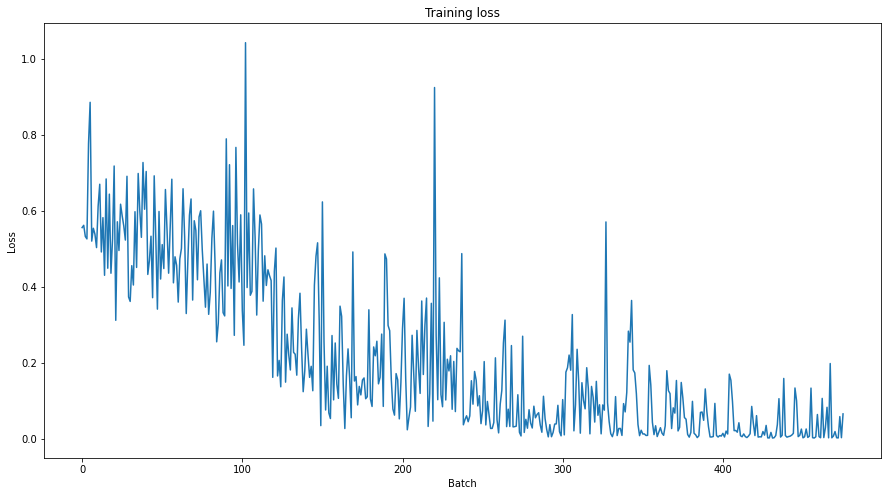

In [50]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

We achieved a validation accuracy of 73% in the last epoch. This is just a demonstration, we might be able to achieve higher accuracies by performing some pre-processing steps and hyper parameter tuning.